## Estimating pseudotime ordering and expression dynamics

In [1]:
%load_ext autotime

import scarf

scarf.__version__

'0.17.1'

time: 1.48 s (started: 2021-08-22 14:57:30 +02:00)


---
### 1) Fetch pre-analyzed data

Here we use the data from [Bastidas-Ponce et al., 2019 Development](https://journals.biologists.com/dev/article/146/12/dev173849/19483/) for E15.5 stage of differentiation of endocrine cells from a pool of endocrine progenitors-precursors. 

We have stored this data on Scarf's online repository for quick access. We processed the data to identify the highly variable genes (top 2000) and create a neighbourhood graph of cells. A UMAP embedding was calculated for the cells. 

In [2]:
scarf.fetch_dataset(
    'bastidas-ponce_4K_pancreas-d15_rnaseq',
    save_path='./scarf_datasets',
    as_zarr=True,
)

INFO: Download finished! File saved here: C:\Users\parashar\Desktop\scarf_vignettes\scarf_datasets\bastidas-ponce_4K_pancreas-d15_rnaseq\data.zarr.tar.gz
INFO: Extracting Zarr file for bastidas-ponce_4K_pancreas-d15_rnaseq
time: 24.9 s (started: 2021-08-22 14:57:32 +02:00)


In [3]:
ds = scarf.DataStore(f"scarf_datasets/bastidas-ponce_4K_pancreas-d15_rnaseq/data.zarr",
                     nthreads=4, default_assay='RNA')

time: 31 ms (started: 2021-08-22 14:57:56 +02:00)


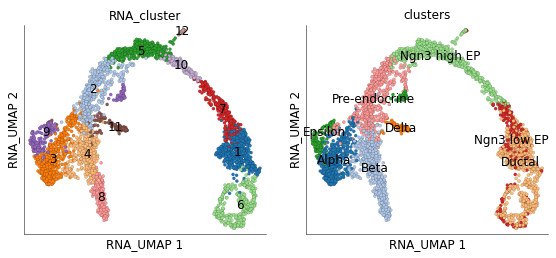

time: 1.03 s (started: 2021-08-22 14:57:56 +02:00)


In [4]:
ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by=['RNA_cluster', 'clusters'],
    width=4, height=4, 
    legend_onside=False, cmap='tab20'
)

---
### 2) Estimate pseudotime ordering

In Scarf we use a memory efficient implementation of [PBA algorithm](https://github.com/AllonKleinLab/PBA) ([Weinreb et al. 2018, PNAS](https://www.pnas.org/content/115/10/E2467)) to estimate a pseudotime ordering of cells. The function `run_pseudotime_ordering` can be run on any Assay for which we have calculated a neighbourhood graph. The the pseudotime is estimated in a supervised manner and hence, the user needs to provide the source (stem/progenitor/precursor cells) and sink (differentiated cell states) cell clusters/groups. 

In [5]:
ds.run_pseudotime_scoring(
    source_sink_key="RNA_cluster",    # Column that contains cluster information 
    sources=[1],                      # Source clusters
    sinks=[3],                        # Sink clusters
)

INFO: Calculating SVD of graph laplacian. This might take a while...


Calculating pseudotime:   0%|                                                                                 …

time: 1.39 s (started: 2021-08-22 14:57:57 +02:00)


By default, the calculated pseudotime values are saved under the cell attribute column **'RNA_pseudotime'**, where 'RNA' can be replaced by whatwever the name of the given assay is. Let's visualize these values on UMAP plot. The lighter color cells represent beginning of the pseudotime

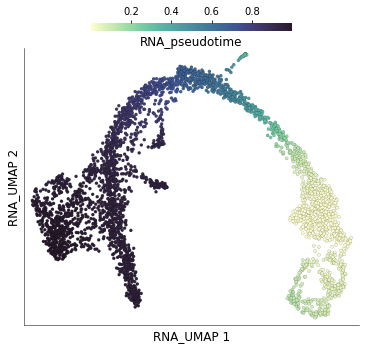

time: 375 ms (started: 2021-08-22 14:57:59 +02:00)


In [6]:
ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by='RNA_pseudotime',
)

---
### 3) Identify pseudotime correlated features

We can now identify the features that are correlated with pseudotime and hence increase or decrease along the pseudotime.`run_pseudotime_marker_search` function will calculate the correlation coefficient for each of the valid features/genes against the pseudotime. The only mandatory parameter that `run_pseudotime_marker_search` function needs is `pseudotime_key` the value of which should the cell attribute column that stores the pseudotime information

In [7]:
ds.run_pseudotime_marker_search(pseudotime_key='RNA_pseudotime')

Finding correlated features:   0%|                                                                            …

time: 11.3 s (started: 2021-08-22 14:57:59 +02:00)


Once calculated, the correlation values against pseudotime are saved under the feature attribute/metadata table ('I__RNA_pseudotime__p', here). The name of of the column is according to this pattern: `<cell_key>__<pseudotime_key>__<p>`. The corresponding p-value is saved under the same column name pattern with suffix `p`

In [8]:
ds.RNA.feats.head()

,I,ids,names,I__RNA_pseudotime__p,I__RNA_pseudotime__r,I__hvgs,dropOuts,highly_variable_genes,nCells
0,False,Xkr4,Xkr4,NaN,NaN,False,3690,False,6
1,False,Gm37381,Gm37381,NaN,NaN,False,3696,True,0
2,False,Rp1,Rp1,NaN,NaN,False,3696,True,0
3,False,Rp1-1,Rp1-1,NaN,NaN,False,3696,True,0
4,False,Sox17,Sox17,NaN,NaN,False,3696,True,0


time: 31 ms (started: 2021-08-22 14:58:11 +02:00)


---
### 4) Visualize pseudotime correlated features

In this section will do deeper on how to use the pseudotime correlation values for further exploratory analysis.

The first step is to export the values in a convenient dataframe format. we can use the `to_pandas_dataframe` methods of the feature attribute table to export the dataframe containing only the columns of choice

In [9]:
corr_genes_df = ds.RNA.feats.to_pandas_dataframe([
    'names',
    'I__RNA_pseudotime__p',
    'I__RNA_pseudotime__r'
], key='I')

# Rename the columns to be shorter
corr_genes_df.columns = ['names', 'p_value', 'r_value']

time: 16 ms (started: 2021-08-22 14:58:11 +02:00)


Let's checkout the genes that are negatively correlated with the pseudotime. These genes increase in expression as the pseudotime progresses., i.e. as cells divide

In [10]:
corr_genes_df.sort_values('r_value')[:15]

,names,p_value,r_value
18864,Spp1,0.0,-0.853747
22385,Rps19,0.0,-0.811618
24581,Rpl13,0.0,-0.808717
431,Dbi,0.0,-0.801796
16254,Rps8,0.0,-0.787065
19815,Rpl32,0.0,-0.777364
3163,Sparc,0.0,-0.775107
26498,Rps4x,0.0,-0.768438
20787,Mgst1,0.0,-0.762069
13425,Rpl12,0.0,-0.754217


time: 16 ms (started: 2021-08-22 14:58:11 +02:00)


Let's visualize the expression of some of these genes on the UMAP plot

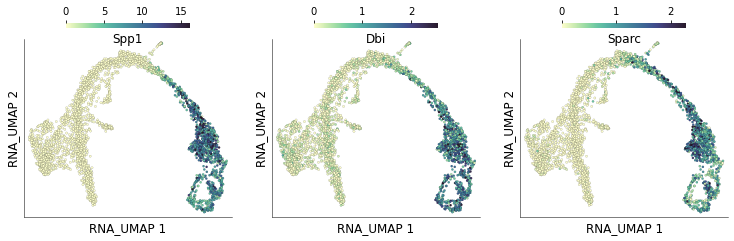

time: 1.34 s (started: 2021-08-22 14:58:11 +02:00)


In [11]:
ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by=['Spp1', 'Dbi', 'Sparc'],
    width=3.5, height=3.5, point_size=5,
)

Now let's checkout the genes that are most positively correlated with the pseudotime. These genes **decrease** in expression as the pseudotime progresses

In [12]:
corr_genes_df.sort_values('r_value', ascending=False)[:10]

,names,p_value,r_value
21244,Aplp1,0.000000e+00,0.717088
14296,Gnas,0.000000e+00,0.708386
23549,Cpe,0.000000e+00,0.703213
3186,Fam183b,0.000000e+00,0.642701
25060,Hmgn3,0.000000e+00,0.614297
26573,Bex2,0.000000e+00,0.608843
8171,Tuba1a,0.000000e+00,0.594564
26730,Pcsk1n,0.000000e+00,0.593595
4284,Ubb,1.342275e-303,0.578068
2189,Rap1b,6.955857e-291,0.568015


time: 16 ms (started: 2021-08-22 14:58:12 +02:00)


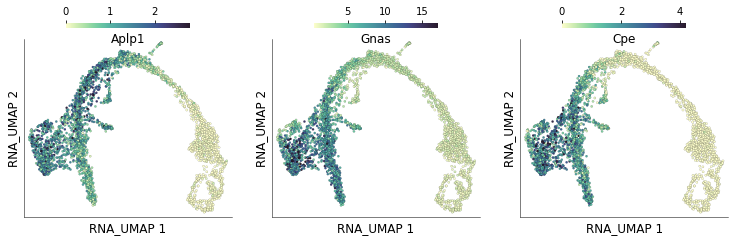

time: 1.26 s (started: 2021-08-22 14:58:12 +02:00)


In [13]:
ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by=['Aplp1', 'Gnas', 'Cpe'],
    width=3.5, height=3.5, point_size=5,
)

---
### 5) Identify feature modules based on pseudotime

`run_pseudotime_marker_search` is excellent to find the genes are linearly correlated with the pseudotime. This function provides us informative statistical metrics to identify genes that are most strongly correlated with the pseudotime. However, with these methods we do not recover all the dynamic patterns of expression along the pseudotime. For example, there might be certain genes that express only in the middle of the trajectory or in one branch of the trajectory.

`run_pseudotime_aggregation` performs two task: 1) It arranges cells along the pseudotime and creates a smoothened, scaled and binned matrix of data 2) Clustering (KNN+Paris) is performed on this matrix to identify the groups of features/genes that have similar expression patterns along the pseudotime.

In [14]:
ds.run_pseudotime_aggregation(
    pseudotime_key='RNA_pseudotime',
    cluster_label='pseudotime_clusters',
    n_clusters = 15,
    window_size=200,
    chunk_size=100,
)

Binning over cell-ordering:   0%|                                                                             …

Fitting KNNs:   0%|                                                                                           …

Identifying feature KNNs:   0%|                                                                               …

INFO: Performing clustering, this might take a while...


Sorting clusters:   0%|                                                                                       …

time: 18 s (started: 2021-08-22 14:58:13 +02:00)


There are two primary results of `run_pseudotime_aggregation`: 
1) The  binned matrix is saved under `aggregate_<cell_key>_<feat_key>_<pseudotime_key>`
2) Feature clusters are saved under feature attributes table

In [15]:
# The binned data matrix. Here we print the shape of the matrix indicating the number of features and numner of bins respectively
ds.z.RNA.aggregated_I_I_RNA_pseudotime.data.shape

(12497, 100)

time: 0 ns (started: 2021-08-22 14:58:31 +02:00)


In [16]:
# Fetching pseudotime based cluster identity of features
ds.RNA.feats.fetch('pseudotime_clusters')

array([ 2, 10,  4, ...,  6, -1,  6])

time: 16 ms (started: 2021-08-22 14:58:31 +02:00)


`plot_pseudotime_heatmap` allows visualizing the binned matrix along with the feature clusters

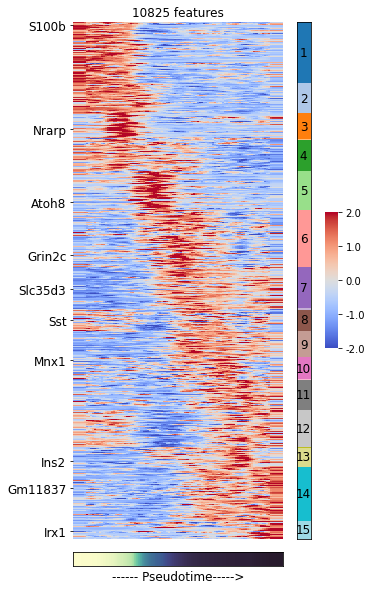

time: 1.19 s (started: 2021-08-22 14:58:31 +02:00)


In [17]:
# Highlighting some marker genes
genes_to_label = ['S100b', 'Nrarp', 'Atoh8', 'Grin2c', 'Slc35d3',
                  'Sst', 'Mnx1', 'Ins2', 'Gm11837', 'Irx1']

ds.plot_pseudotime_heatmap(
    cell_key='I',
    feat_key='I',
    feature_cluster_key='pseudotime_clusters',
    pseudotime_key='RNA_pseudotime',
    show_features=genes_to_label
)

The heatmap above shows the gene expression dynamics as the cells progress throught the pseudotime. Here, cluster 1 captures the genes that have highest expression in early pseudotime while cluster 15 captures genes whose expression peak in the late pseudotime.

We can visualize the expression of the above selected genes on UMAP to check whether their cluster identity corroborates their expression pattern.

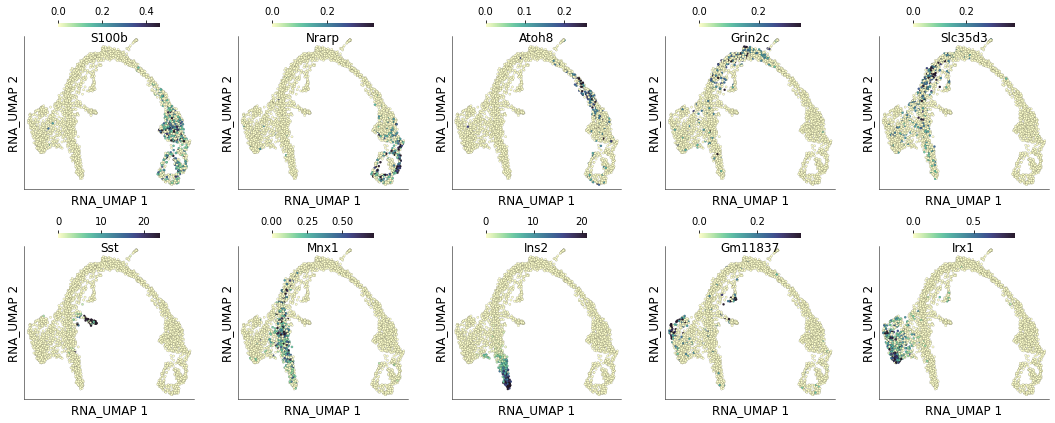

time: 4.25 s (started: 2021-08-22 14:58:33 +02:00)


In [18]:
ds.plot_layout(
    layout_key='RNA_UMAP', color_by=genes_to_label,
    width=3, height=3, point_size=5, n_columns=5,
)

---
### 6) Merging pseudotime-based feature modules into a new assay

The pseudotime based clusters of features can be used create a new assay. `add_grouped_assay` will take each cluster and take the mean expression of genes from that cluster and add it to a new assay. The motivation behind this approach is that we do not have to add many columns to our cell metadata table and have the mean cluster values readily available for analysis.

Taking mean cluster values is a powerful approach that allows use to explore cumulative pattern of highly correlated genes. Here we create a new assay under title `PTIME_MODULES`

In [19]:
ds.add_grouped_assay(
    group_key='pseudotime_clusters',
    assay_label='PTIME_MODULES'
)

Writing to Zarr:   0%|                                                                                        …

(PTIME_MODULES) Computing nCells and dropOuts:   0%|                                                          …

(PTIME_MODULES) Computing nCounts:   0%|                                                                      …

(PTIME_MODULES) Computing nFeatures:   0%|                                                                    …

time: 5.03 s (started: 2021-08-22 14:58:37 +02:00)


In [20]:
# DataStore summary showing `PTIME_MODULES` assay with 15 features (number of pseudotime based feature clusters)
ds

DataStore has 3413 (3696) cells with 2 assays: PTIME_MODULES RNA
   Cell metadata:
            'I', 'ids', 'names', 'G2M_score', 'PTIME_MODULES_nCounts', 
            'PTIME_MODULES_nFeatures', 'RNA_G2M_score', 'RNA_S_score', 'RNA_UMAP1', 'RNA_UMAP2', 
            'RNA_cell_cycle_phase', 'RNA_cluster', 'RNA_nCounts', 'RNA_nFeatures', 'RNA_percentMito', 
            'RNA_percentRibo', 'RNA_pseudotime', 'S_score', 'clusters', 'clusters_coarse', 
          
   PTIME_MODULES assay has 15 (15) features and following metadata:
            'I', 'ids', 'names', 'dropOuts', 'nCells', 
          
   RNA assay has 12497 (27998) features and following metadata:
            'I', 'ids', 'names', 'I__RNA_pseudotime__p', 'I__RNA_pseudotime__r', 
            'I__hvgs', 'dropOuts', 'highly_variable_genes', 'nCells', 'pseudotime_clusters', 
          

time: 32 ms (started: 2021-08-22 14:58:42 +02:00)


The mean values from each cluster are saved within the assay and tagged with names like `group_1`, `group_2`, etc

In [21]:
ds.PTIME_MODULES.feats.head()

,I,ids,names,dropOuts,nCells
0,True,group_1,group_1,0,3696
1,True,group_2,group_2,0,3696
2,True,group_3,group_3,0,3696
3,True,group_4,group_4,0,3696
4,True,group_5,group_5,0,3696


time: 16 ms (started: 2021-08-22 14:58:42 +02:00)


We can visualize these cluster mean values directly on the UMAP like this:

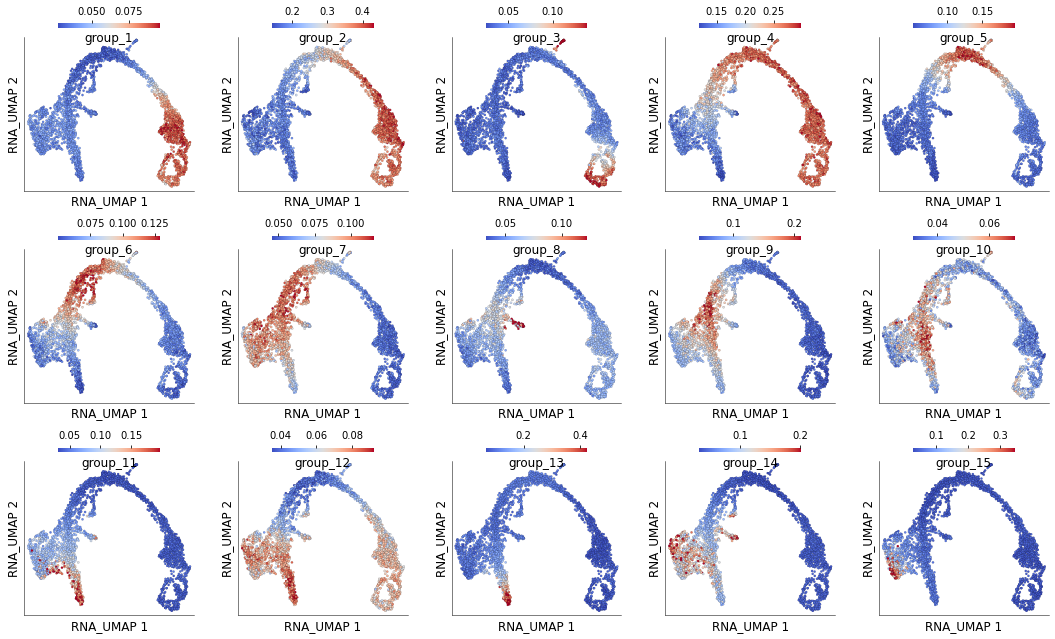

time: 5.59 s (started: 2021-08-22 14:58:42 +02:00)


In [22]:
n_clusters = 15
ds.plot_layout(
    from_assay='PTIME_MODULES',
    layout_key='RNA_UMAP', 
    color_by=[f"group_{i}" for i in range(1,n_clusters+1)],
    width=3, height=3, point_size=5, n_columns=5, cmap='coolwarm',
)

This figure complements the heatmap we generated earlier very nicely. Using this approach we have clearly found **gene modules** that are restricted in expression to certain portion of the pseudotime and differentiation trajectory

---
### 7) Comparing pseudotime based feature modules with cluster markers

Here we will compare the pseudotime based feature module extraction approach with classical cluster marker approach.

In [23]:
# Running marker search
ds.run_marker_search(group_key='RNA_cluster')

Finding markers:   0%|                                                                                        …

time: 12.3 s (started: 2021-08-22 14:58:48 +02:00)


Here we extract features from pseudotime-based cluster/group 13. These genes are the ones that show high expressio in Beta cells. 

In [24]:
ptime_feat_clusts = ds.RNA.feats.to_pandas_dataframe(['names', 'pseudotime_clusters'])
ptime_based_markers = ptime_feat_clusts.names[ptime_feat_clusts.pseudotime_clusters == 13]
ptime_based_markers.head()

25     Tram1
87     Uggt1
383    Hdlbp
580     Ier5
663     Uck2
Name: names, dtype: object

time: 15 ms (started: 2021-08-22 14:59:00 +02:00)


Now we extract all the marker genes for cell cluster 8, this cluster predominantly contains the Beta cells.

In [25]:
cell_cluster_markers = ds.get_markers(group_key='RNA_cluster', group_id='8')['names']
cell_cluster_markers.head()

22131        Ins2
20303         Npy
26555       Sytl4
26880    Arhgap36
16755     Tmem215
Name: names, dtype: object

time: 16 ms (started: 2021-08-22 14:59:00 +02:00)


In [26]:
# let's checkout the number of Beta cell associated genes from both methods
ptime_based_markers.shape, cell_cluster_markers.shape

((405,), (107,))

time: 0 ns (started: 2021-08-22 14:59:00 +02:00)


In [27]:
# let's checkout the number of common Beta cell associated genes from both methods
len(set(cell_cluster_markers.index).intersection(ptime_based_markers.index))

66

time: 0 ns (started: 2021-08-22 14:59:00 +02:00)


Let's visualize the cumulative expression of genes that are present only in cluster marker based approach

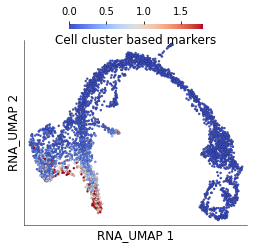

time: 594 ms (started: 2021-08-22 14:59:00 +02:00)


In [28]:
temp = list(set(cell_cluster_markers.index).difference(ptime_based_markers.index))
ds.cells.insert('Cell cluster based markers', ds.RNA.normed(feat_idx=sorted(temp)).mean(axis=1).compute(), overwrite=True)
ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by='Cell cluster based markers',
    width=4, height=4, point_size=5, n_columns=5, cmap='coolwarm',
)

Let's now do this the other way and visualize the cumulative expression of genes that are present only in pseudotime-based approach

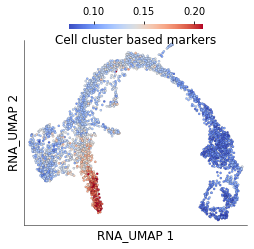

time: 579 ms (started: 2021-08-22 14:59:37 +02:00)


In [29]:
temp = list(set(ptime_based_markers.index).difference(cell_cluster_markers.index))
ds.cells.insert('Cell cluster based markers', ds.RNA.normed(feat_idx=sorted(temp)).mean(axis=1).compute(), overwrite=True)
ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by='Cell cluster based markers',
    width=4, height=4, point_size=5, n_columns=5, cmap='coolwarm',
)

The pseudotime-based approach clearly captures a lot of signal that would be otherwise missed by simply taking a cell cluster marker based approach. 

---
That is all for this vignette.